In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

In [3]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

/tmp/ipython-input-2538754208.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})


In [4]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Separate the data into DataLoaders

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the model and a training regimen

In [6]:
class ANN_CLASS(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear( 4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12, 3)

        # parameters
        self.dr = dropoutRate

        # forward pass
    def forward(self,x):

        # input
        x = F.relu( self.input(x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()

        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x,p=self.dr,training=self.training)

        # output
        x = self.output(x)
        return x

In [7]:
# a function that creates the ANN model

def ANN_MODEL(dropoutrate):

    # grab an instance of the model class
    ANN = ANN_CLASS(dropoutrate)

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005)

    return ANN,lossfunc,optim

In [8]:
# train the model

# global parameter
epochs = 1000

def train():

    # initialize accuracies as empties (not storing losses here)
    train_accuracy = []
    test_accuracy  = []

    # loop over epochs
    for i in range(epochs):

        # switch learning on
        ANN.train()

    # loop over training data batches
    batch_accuracy = []
    for X,y in train_loader:
        # forward pass and loss
        yHat = ANN(X)
        loss = lossfunc(yHat,y)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # compute training accuracy just for this batch
        batch_accuracy.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
        # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    train_accuracy.append( np.mean(batch_accuracy) )

    # test accuracy
    ANN.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANN(X),axis=1 )
    test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

    # function output
    return train_accuracy,test_accuracy


# Experiment Code

In [9]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # create and train the model
    ANN,lossfunc,optim = ANN_MODEL(dropoutRates[di])
    train_accuracy,test_accuracy = train()

    # store accuracies
    results[di,0] = np.mean(train_accuracy[-50:])
    results[di,1] = np.mean(test_accuracy[-50:])


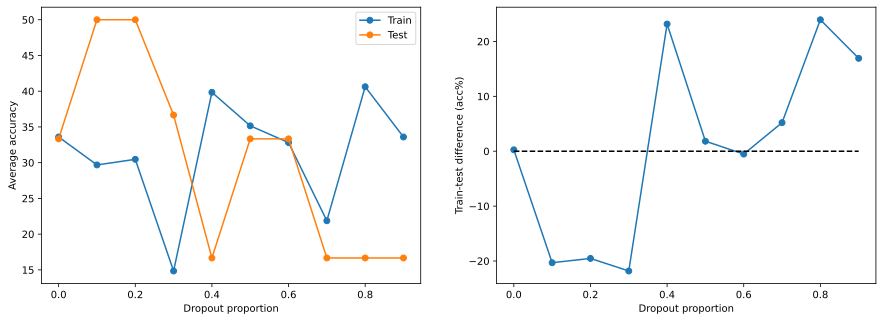

In [10]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Experiments

1. Change the activation function into a different activation function and re-run the code, compare the result with the ReLU activation function. Does different activation function affect the performance of the dropout?

2. Create a wide network using ReLU as the activation function and conduct the same experiment, compare the result to that of the original code.

3. Create a more complex model by adding more layers into the architecture, conduct the same experiment, compare the result to that of the original code.

/tmp/ipython-input-713926928.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})


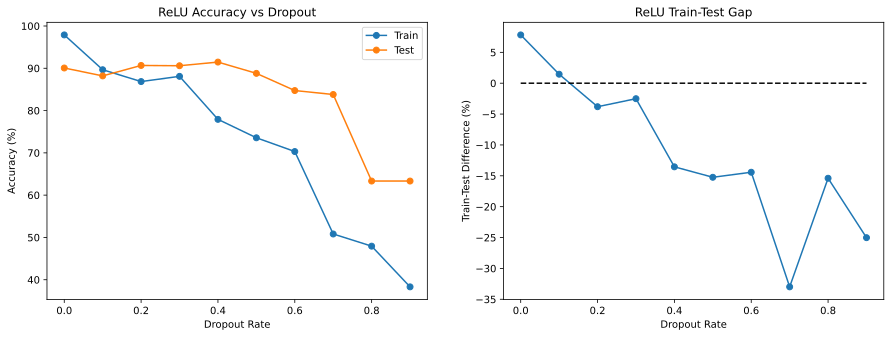

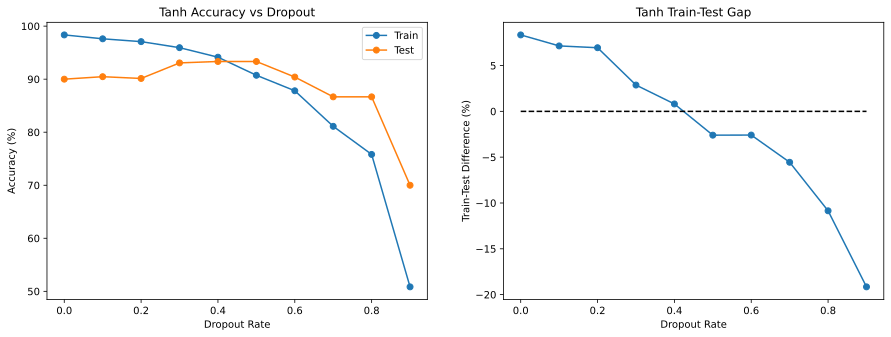

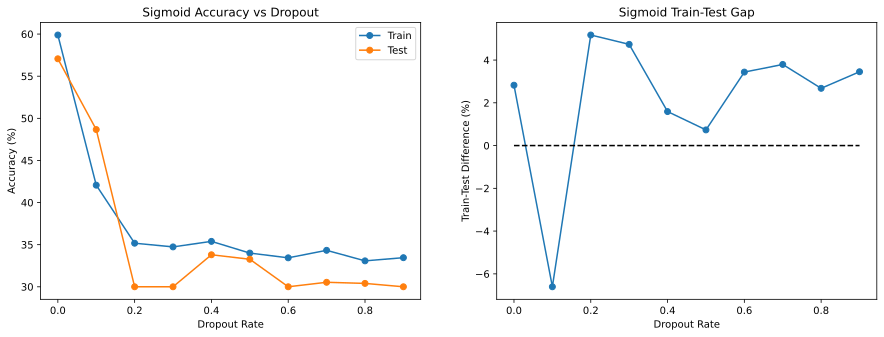

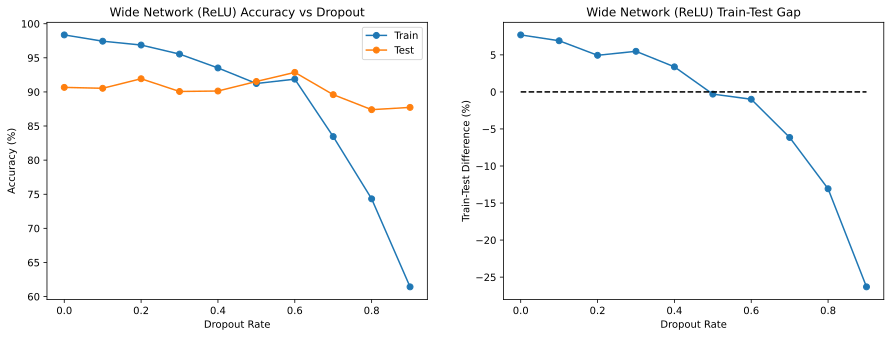

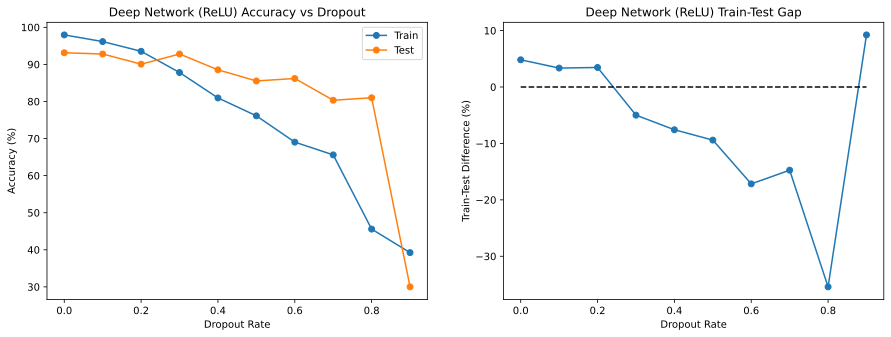

In [11]:
# Trying the Experiments

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess Iris dataset
iris = fetch_ucirepo(id=53)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(iris.data.features), columns=iris.data.features.columns)
y = iris.data.targets.copy()
y["class"] = y["class"].replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).squeeze().long()

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_data))

class ANN_Activation(nn.Module):
    def __init__(self, dropoutRate, activation_fn):
        super().__init__()
        self.input = nn.Linear(4, 12)
        self.hidden = nn.Linear(12, 12)
        self.output = nn.Linear(12, 3)
        self.dr = dropoutRate
        self.act = activation_fn

    def forward(self, x):
        x = self.act(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = self.act(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        return self.output(x)

class ANN_Wide(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.input = nn.Linear(4, 64)
        self.hidden = nn.Linear(64, 64)
        self.output = nn.Linear(64, 3)
        self.dr = dropoutRate

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        return self.output(x)

class ANN_Deep(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(dropoutRate),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(dropoutRate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropoutRate),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        return self.layers(x)

def train_model(model, lossfunc, optim, epochs=1000):
    train_acc, test_acc = [], []
    for _ in range(epochs):
        model.train()
        batch_acc = []
        for X, y in train_loader:
            yHat = model(X)
            loss = lossfunc(yHat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            batch_acc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        train_acc.append(np.mean(batch_acc))

        model.eval()
        X, y = next(iter(test_loader))
        pred = torch.argmax(model(X), axis=1)
        test_acc.append(100 * torch.mean((pred == y).float()).item())
    return train_acc, test_acc

def run_experiment(model_class, label, activation_fn=None):
    dropoutRates = np.arange(0, 1.0, 0.1)
    results = np.zeros((len(dropoutRates), 2))

    for i, dr in enumerate(dropoutRates):
        if activation_fn:
            model = model_class(dr, activation_fn)
        else:
            model = model_class(dr)
        lossfunc = nn.CrossEntropyLoss()
        optim = torch.optim.SGD(model.parameters(), lr=0.005)
        train_acc, test_acc = train_model(model, lossfunc, optim)
        results[i, 0] = np.mean(train_acc[-50:])
        results[i, 1] = np.mean(test_acc[-50:])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(dropoutRates, results, 'o-')
    ax[0].set_title(f'{label} Accuracy vs Dropout')
    ax[0].set_xlabel('Dropout Rate')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].legend(['Train', 'Test'])

    ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
    ax[1].plot([0, 0.9], [0, 0], 'k--')
    ax[1].set_title(f'{label} Train-Test Gap')
    ax[1].set_xlabel('Dropout Rate')
    ax[1].set_ylabel('Train-Test Difference (%)')
    plt.show()

    # 1. Activation Function Comparison
run_experiment(ANN_Activation, "ReLU", activation_fn=F.relu)
run_experiment(ANN_Activation, "Tanh", activation_fn=torch.tanh)
run_experiment(ANN_Activation, "Sigmoid", activation_fn=torch.sigmoid)

# 2. Wide Network
run_experiment(ANN_Wide, "Wide Network (ReLU)")

# 3. Deep Network
run_experiment(ANN_Deep, "Deep Network (ReLU)")